In [1]:
# Importing all the required libraries 
import pandas as pd                      # for basic text/dataframe manipulation
import nltk; nltk.download('stopwords')  # to get english stopwords and for lemitization

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pushpa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Importing the dataset
with open("C:/Users/Pushpa/Downloads/nytimes_news_articles.txt", "r",encoding='utf-8-sig') as input:
    input_data = input.read().split("\n\n")
input_data = pd.DataFrame(input_data, columns=['Articles']) # Reading as dataframe and defining col name
input_data=input_data[~input_data["Articles"].str.startswith('URL:')] # Removing row containing url link
input_data.shape  # staructure of the data frame

(8902, 1)

In [3]:
input_data.head()  # viewing the input data set to see if its properly parsed

,Articles
1,WASHINGTON — Stellar pitching kept the Mets af...
3,Mayor Bill de Blasio’s counsel and chief legal...
5,In the early morning hours of Labor Day last y...
7,It was the Apple Store in New York City before...
9,OMAHA — The United States Olympic swimming tri...


In [4]:
# Preparing the dataset for LDA
# Word Tokenization
input_data =input_data[0:1000]
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Convert to list
data = input_data.Articles.values.tolist()
data_words = list(sent_to_words(input_data["Articles"]))

print(data_words[1:])

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
#print(trigram_mod[bigram_mod[data_words[0]]])

In [6]:
# Remove Stopwords, Make Bigrams and Lemmatize
# Define functions for stopwords, bigrams, trigrams and lemmatization
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [7]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

#print(data_lemmatized[1:])

In [8]:
# Create the Dictionary and Corpus needed for Topic Modeling
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[:1])
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('add', 2),
  ('ahead', 1),
  ('allow', 1),
  ('already', 1),
  ('anti', 1),
  ('appear', 1),
  ('ask', 2),
  ('average', 3),
  ('back', 2),
  ('bad', 1),
  ('ball', 1),
  ('base', 1),
  ('baseball', 1),
  ('batter', 1),
  ('beat', 1),
  ('bone', 1),
  ('bone_spur', 1),
  ('bruise', 1),
  ('build', 1),
  ('butt', 1),
  ('calf', 1),
  ('can', 1),
  ('career', 1),
  ('chance', 2),
  ('change', 1),
  ('coach', 1),
  ('collin', 5),
  ('come', 1),
  ('compete', 1),
  ('continue', 1),
  ('cruel', 1),
  ('day', 2),
  ('deficit', 1),
  ('different', 1),
  ('discuss', 1),
  ('double', 1),
  ('drive', 1),
  ('driving', 1),
  ('dynamic', 1),
  ('early', 1),
  ('effect', 1),
  ('eighth', 2),
  ('eighth_inne', 1),
  ('elbow', 2),
  ('encore', 1),
  ('enter', 1),
  ('especially', 1),
  ('even', 4),
  ('expect', 1),
  ('extra', 1),
  ('fall', 1),
  ('feel', 1),
  ('field', 1),
  ('first', 2),
  ('flounder', 1),
  ('frustrating', 1),
  ('game', 6),
  ('get', 1),
  ('give', 8),
  ('go'

In [9]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [10]:
# Print the Keyword in the 15 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [11]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.898268474598991

Coherence Score:  0.4541994321706042


In [27]:
# Hyperparameter tuning
min_topics = 3
max_topics =15
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

model_results = {'Number of Topics': [],
                 'Coherence': []
                }
for k in topics_range:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word, num_topics=k, 
                                           random_state=100, update_every=1,chunksize=100,
                                           passes=10, alpha='auto',per_word_topics=True)    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
        # get the coherence score for the given parameters
    model_results['Number of Topics'].append(k)
    model_results['Coherence'].append(coherence_lda)


In [28]:
model_results = pd.DataFrame(model_results)
model_results

,Number of Topics,Coherence
0,3,0.320621
1,4,0.316588
2,5,0.365076
3,6,0.348901
4,7,0.449169
5,8,0.366005
6,9,0.417924
7,10,0.510838
8,11,0.477839
9,12,0.483254


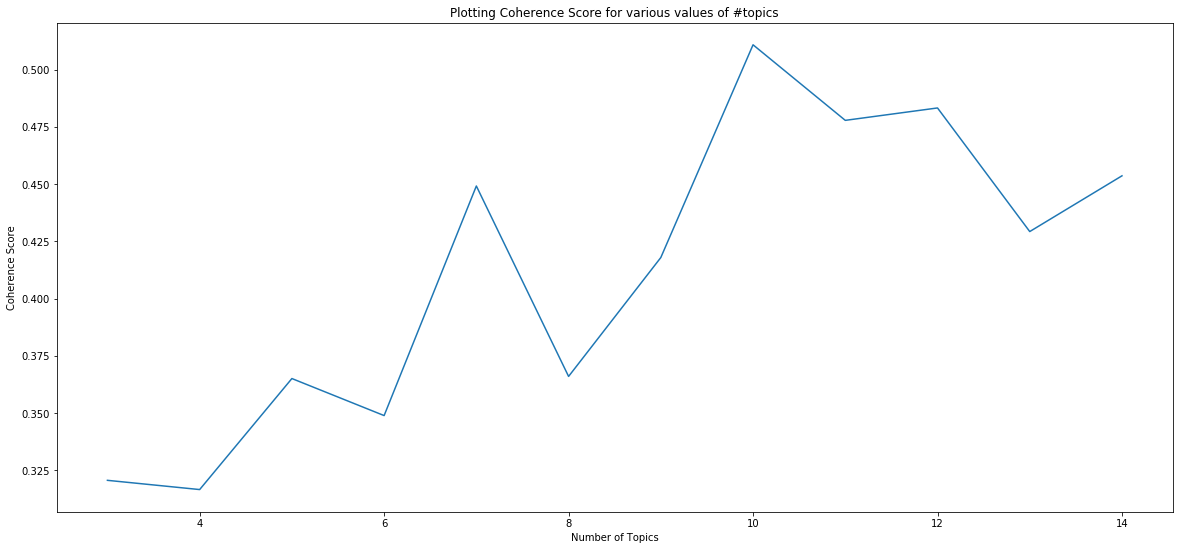

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.figure(figsize = (20,9))
sns.lineplot(x = "Number of Topics", y =  "Coherence", data = model_results );
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Plotting Coherence Score for various values of #topics");

In [13]:
# Best Model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


In [14]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.504900264095735

Coherence Score:  0.5108384496145877


In [15]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.5014,"say, go, time, know, people, take, show, make,...","[stellar, pitching, keep, met, first, last, se..."
1,1,9.0,0.4879,"say, year, company, would, also, use, report, ...","[chief, legal, adviser, resign, next, become, ..."
2,2,1.0,0.6654,"say, go, time, know, people, take, show, make,...","[early, morning, hour, labor, day, last, year,..."
3,3,6.0,0.4951,"student, school, college, make, year, use, wor...","[store, city, thing, apple, store, ipod, ipad,..."
4,4,1.0,0.5454,"say, go, time, know, people, take, show, make,...","[spectacle, build, strapped, sport, broad, cli..."
5,5,1.0,0.4487,"say, go, time, know, people, take, show, make,...","[race, third, olympic_trial, heat, meter, back..."
6,6,9.0,0.6122,"say, year, company, would, also, use, report, ...","[lionsgate, film, studio, hunger, home, person..."
7,7,1.0,0.4097,"say, go, time, know, people, take, show, make,...","[slate, colored, light, slant, skylight, woman..."
8,8,1.0,0.4144,"say, go, time, know, people, take, show, make,...","[coach, deliver, truth, afternoon, team, lot, ..."
9,9,5.0,0.5044,"say, would, vote, leave, country, campaign, co...","[rejoice, apparent, victory, scene, tone, coul..."


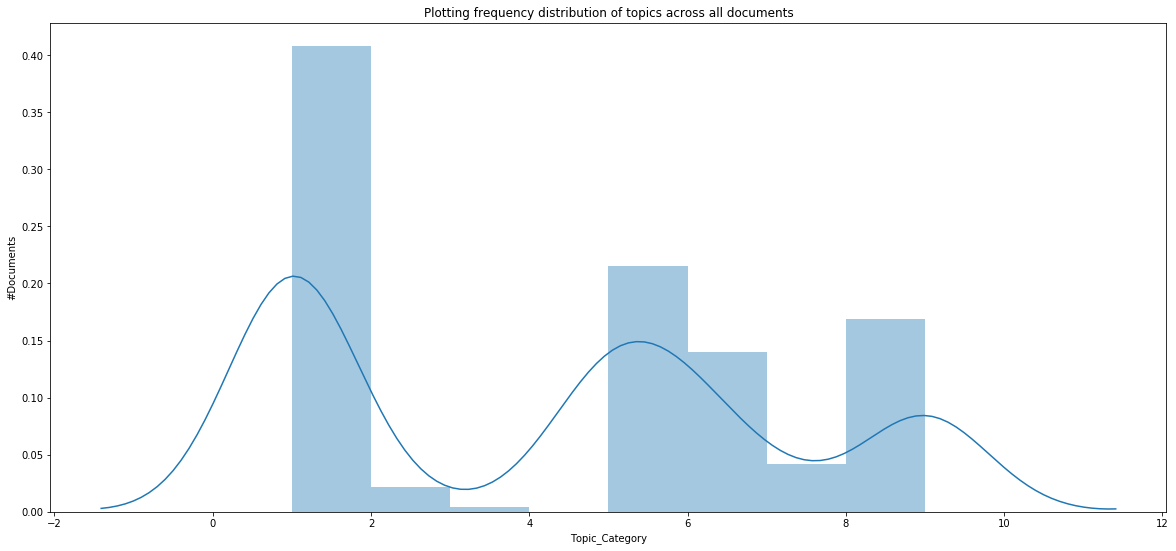

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.figure(figsize = (20,9))
sns.distplot(df_dominant_topic["Dominant_Topic"]);
plt.xlabel("Topic_Category")
plt.ylabel("#Documents")
plt.title("Plotting frequency distribution of topics across all documents");

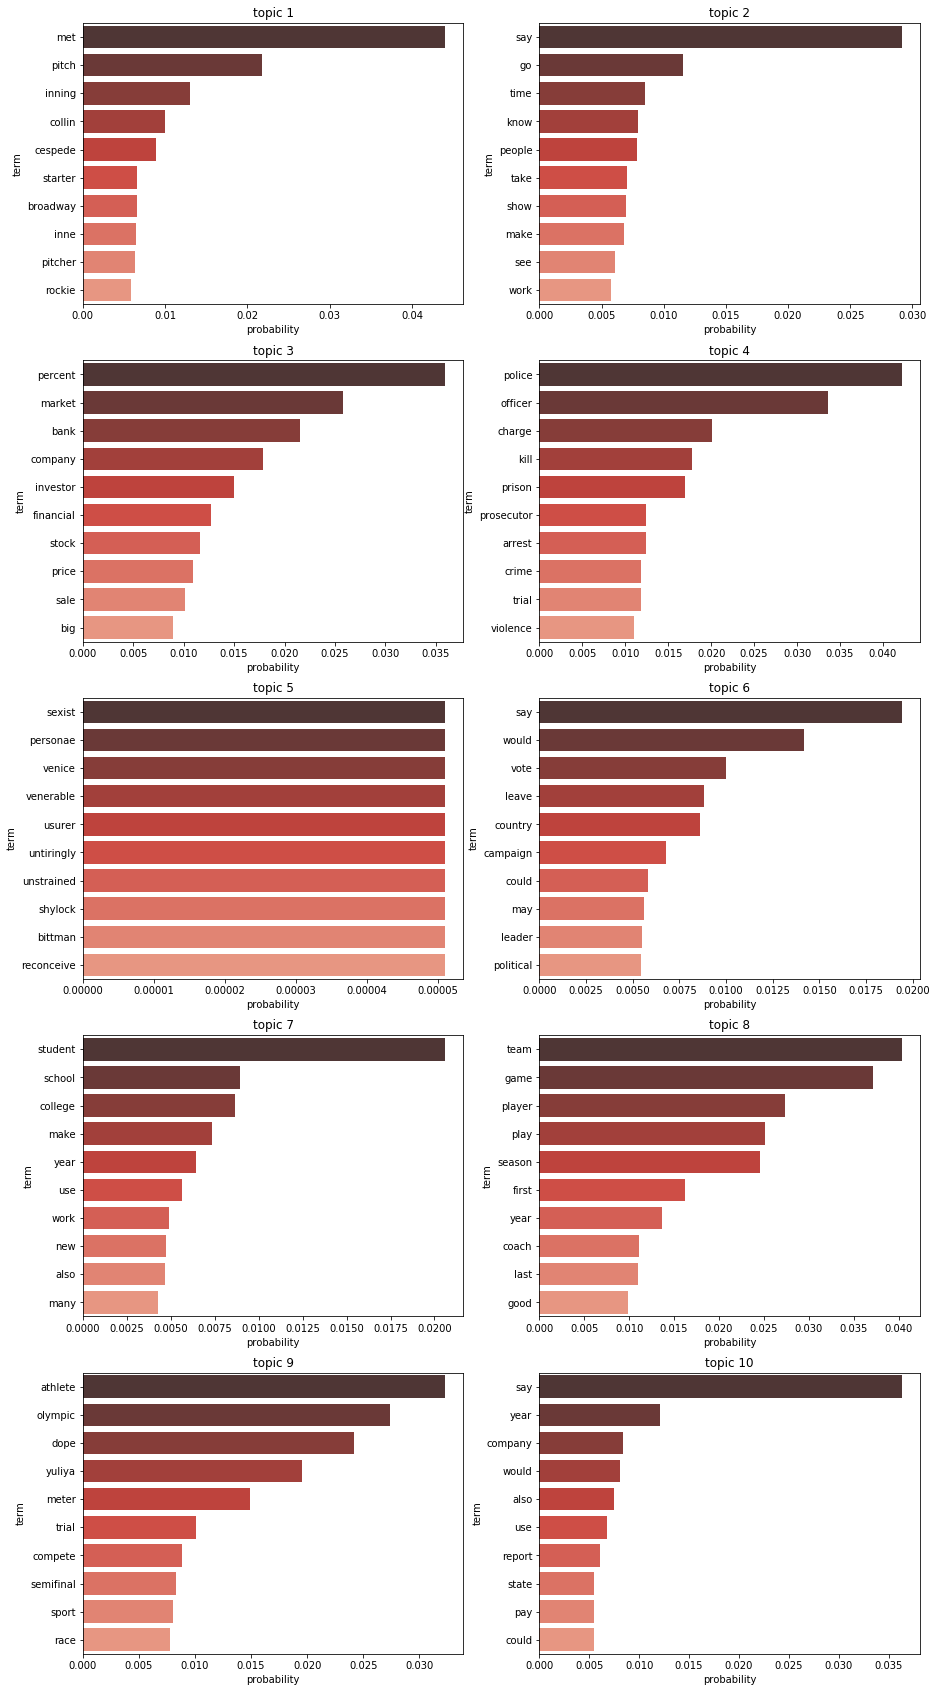

In [23]:
#lda_model.show_topic(5)
fiz=plt.figure(figsize=(15,30))
for i in range(10):
    df=pd.DataFrame(lda_model.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='Reds_d')
    plt.xlabel('probability')
    

plt.show()

In [24]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word,mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.251807  0.192237       1        1  34.521961
5      0.117956  0.276631       2        1  21.030165
9     -0.183861  0.257194       3        1  19.688749
6     -0.037969  0.294291       4        1  15.682117
7      0.330984 -0.073831       5        1   4.200974
2     -0.326656 -0.009225       6        1   2.916619
3     -0.090275 -0.367573       7        1   1.231980
8     -0.102858 -0.199124       8        1   0.512882
0      0.045187 -0.207135       9        1   0.212253
4     -0.004313 -0.163466      10        1   0.002296, topic_info=              Term         Freq        Total Category  logprob  loglift
1201       percent   822.000000   822.000000  Default  30.0000  30.0000
1814       student  1078.000000  1078.000000  Default  29.0000  29.0000
171           team   652.000000   652.000000  Default  28.0000  28.0000
120           play   693.000000   693.000000  Default  27.0000  27.0000
57            game   554.000000   554.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
6507      nowadays     0.000391     0.756928  Topic10  -9.8825   3.1134
6508     obsessive     0.000391     0.739925  Topic10  -9.8825   3.1361
6509  ostentatious     0.000391     0.738808  Topic10  -9.8825   3.1376
6510          plus     0.000391     0.749888  Topic10  -9.8825   3.1227
6511          polo     0.000391     0.743814  Topic10  -9.8825   3.1309

[635 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
5509       2  0.992845  abortion
5346       2  0.015372  academic
5346       4  0.983794  academic
4418       3  0.990149  accident
191        1  0.025574    accord
...      ...       ...       ...
190        6  0.024581      year
1823       1  0.809789     young
1823       2  0.089425     young
1823       4  0.099361     young
19466      8  0.966621    yuliya

[1106 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 10, 7, 8, 3, 4, 9, 1, 5])